# Зависимости

In [1]:
pip -q install torch torchvision torchaudio transformers sentence-transformers scikit-learn datasets accelerate


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
pip install seaborn

     -------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Импорт, чтение и сплит

In [ ]:
import json, os, random, math
from pathlib import Path
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import requests 

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# подгружаем датасеты через GitHub
BASE_URL = "https://raw.githubusercontent.com/Fla1lx/neural-network-module-for-determining-user-intent/main"

TRAIN_URL = f"{BASE_URL}/lbd_train_augmented.jsonl"
DEV_URL   = f"{BASE_URL}/lbd_dev_augmented.jsonl" 

def load_jsonl_from_url(url: str):
    resp = requests.get(url)
    resp.raise_for_status()
    lines = resp.text.splitlines()
    return [json.loads(line) for line in lines if line.strip()]

rows     = load_jsonl_from_url(TRAIN_URL)
dev_rows = load_jsonl_from_url(DEV_URL)

print("train samples:", len(rows))
print("train by skill:", Counter(r["skill"] for r in rows))
print("dev samples:", len(dev_rows))
print("dev by skill:", Counter(r["skill"] for r in dev_rows))


train samples: 8800
train by skill: Counter({'math.calculate': 821, 'music.stop': 819, 'system.help': 816, 'alarm.set': 810, 'jokes.tell': 807, 'time.now': 800, 'music.play': 794, 'timer.start': 789, 'news.get': 787, 'reminder.add': 779, 'weather.get': 778})
dev samples: 2200
dev by skill: Counter({'weather.get': 222, 'reminder.add': 221, 'news.get': 213, 'timer.start': 211, 'music.play': 206, 'time.now': 200, 'jokes.tell': 193, 'alarm.set': 190, 'system.help': 184, 'music.stop': 181, 'math.calculate': 179})


Config

In [4]:
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Any, Tuple
import os
import random
import numpy as np
import torch

@dataclass
class Config:
    SEED: int = 42
    MAX_LEN: int = 128
    
    # Архитектура модели
    EMB_DIM: int = 96
    CNN_CHANNELS: int = 128
    LSTM_HIDDEN: int = 128
    PROJ_DIM: int = 128
    
    # Обучение
    EPOCHS: int = 15
    LR: float = 3e-4
    LAMBDA: float = 0.2  # Вес SupCon loss
    PATIENCE: int = 3
    BATCH_SIZE: int = 64
    
    # Специальные токены
    SPECIALS: List[str] = field(default_factory=lambda: ["<pad>", "<unk>", "<bos>", "<eos>"])
    PAD_IDX: int = 0
    UNK_IDX: int = 1
    BOS_IDX: int = 2
    EOS_IDX: int = 3
    
    # Параметры ранжирования
    RANK_ALPHA: float = 0.4   # Вес FAISS similarity
    RANK_BETA: float = 0.4    # Вес вероятности нейросети
    RANK_GAMMA: float = 0.1   # Вес базового веса скилла
    THRESHOLD: float = 0.4    # Порог уверенности
    
    # Параметры негативных примеров
    NEGATIVE_WEIGHT: float = 1.5  # Множитель "силы" негативных примеров
    NEGATIVE_MARGIN: float = 0.1  # Минимальная разница для отклонения интента
    FAISS_K: int = 5

@dataclass 
class SkillConfig:
    name: str
    base_weight: float = 0.5
    positive_keywords: List[str] = field(default_factory=list)
    exclusion_keywords: List[str] = field(default_factory=list)
    requires_slot: List[str] = field(default_factory=list)

# Настройка поведения скиллов (Keyword spotting + Logic)
SKILL_CONFIGS = {
    "music.play": SkillConfig(
        name="music.play",
        base_weight=0.5,
        positive_keywords=["включи", "поставь", "запусти", "воспроизведи", "сыграй", "музыку", "песню", "трек"],
        exclusion_keywords=["будильник", "таймер", "напоминание", "alarm"],
    ),
    "alarm.set": SkillConfig(
        name="alarm.set",
        base_weight=0.5,
        positive_keywords=["будильник", "разбуди", "побудку", "аларм", "будик"],
        exclusion_keywords=[],
        requires_slot=["time"],
    ),
    "timer.start": SkillConfig(
        name="timer.start",
        base_weight=0.5,
        positive_keywords=["таймер", "засеки", "отсчет", "засечь"],
        exclusion_keywords=["будильник"],
        requires_slot=["duration"],
    ),
    "reminder.add": SkillConfig(
        name="reminder.add",
        base_weight=0.5,
        positive_keywords=["напомни", "напоминание", "не забыть", "запомни"],
        exclusion_keywords=["будильник", "таймер"],
    ),
    "weather.get": SkillConfig(
        name="weather.get",
        base_weight=0.5,
        positive_keywords=["погода", "прогноз", "градусов", "осадки", "дождь", "снег", "ветер"],
        exclusion_keywords=[],
    ),
    "music.stop": SkillConfig(
        name="music.stop",
        base_weight=0.5,
        positive_keywords=["выключи", "останови", "стоп", "пауза", "хватит"],
        exclusion_keywords=["будильник", "таймер"],
    ),
    "time.now": SkillConfig(
        name="time.now",
        base_weight=0.5,
        positive_keywords=["время", "час", "который час"],
        exclusion_keywords=["погода", "будильник", "напомни"],
    ),
    "news.get": SkillConfig(
        name="news.get",
        base_weight=0.5,
        positive_keywords=["новости", "сводки", "новенького"],
        exclusion_keywords=[],
    ),
    "jokes.tell": SkillConfig(
        name="jokes.tell",
        base_weight=0.5,
        positive_keywords=["анекдот", "шутка", "смешное", "прикол", "угарнем"],
        exclusion_keywords=[],
    ),
    "math.calculate": SkillConfig(
        name="math.calculate",
        base_weight=0.5,
        positive_keywords=["посчитай", "сколько будет", "плюс", "минус", "умножь", "раздели", "корень", "степень"],
        exclusion_keywords=[],
    ),
    "system.help": SkillConfig(
        name="system.help",
        base_weight=0.3,  # Чуть ниже, чтобы не перебивал конкретные интенты
        positive_keywords=["помощь", "что умеешь", "команды", "функции", "возможности", "как"],
        exclusion_keywords=[],
    ),
}

def get_config(): return Config()
def get_skill_config(name): return SKILL_CONFIGS.get(name, SkillConfig(name=name))

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

seed_everything(Config.SEED)

# Маскирование + Токенайзер
Находим в тексте ключевые слова и заменяем на плейсхолдевы (masked , slots)

In [5]:
import re

@dataclass
class MaskResult:
    original: str
    masked: str
    slots: Dict[str, List[str]]

# Константы (из masking.py)
TIME_WORDS = r"(сегодня|завтра|послезавтра|утром|днём|днем|вечером|ночью)"
MONTHS = r"(январ[ьяе]|феврал[ьяе]|март[ае]?|апрел[ьяе]|ма[ея]|июн[ьяе]|июл[ьяе]|август[ае]?|сентябр[ьяе]|октябр[ьяе]|ноябр[ьяе]|декабр[ьяе])"
UNITS = r"(секунд(?:а|ы)?|минут(?:а|ы)?|час(?:а|ов)?|дн(?:я|ей|ь))"
PREP = r"(?:в|во|на|из|по|к|у|с|со|под|над|около|между)"
CAP_WORD = r"[A-ZА-ЯЁ][\w\-]+"
CITY_LIST = ["москва","санкт-петербург","казань","берлин","лондон","париж","екатеринбург","новосибирск"]

# Хелперы
def _store(slots, key, value, placeholder, canon_key=None, canon_val=None):
    slots.setdefault(key, []).append(value.strip())
    if canon_key: slots.setdefault(canon_key, []).append(canon_val)
    return placeholder

def _canon(text): return re.sub(r"\s+", " ", text.strip())

def _merge_spans(spans):
    spans = sorted(spans, key=lambda x: (x[0], x[1]))
    merged = []
    for s in spans:
        if not merged or s[0] >= merged[-1][1]:
            merged.append(s)
        else:
            if (s[1] - s[0]) > (merged[-1][1] - merged[-1][0]):
                merged[-1] = s
    return merged

# Regex компиляция для городов (упрощенная версия из masking.py)
def _city_regex(city):
    return re.compile(re.escape(city)[:-1] + r"[а-я]*", flags=re.I) # Упрощено для краткости
CITY_PATTERNS = [(c, _city_regex(c)) for c in CITY_LIST]

def mask_entities(text: str) -> MaskResult:
    slots = {}
    raw = text
    spans = []
    
    # Защита существующих тегов
    protected = []
    for m in re.finditer(r"\{[a-z_]+\}", raw): protected.append((m.start(), m.end()))
    def _is_protected(a,b): return any(not (b<=x or a>=y) for x,y in protected)

    # Логика извлечения (та же, что и была, но структурированная)
    # TIME
    for m in re.finditer(r"\b([01]?\d|2[0-3]):[0-5]\d\b", raw):
        if not _is_protected(m.start(), m.end()): spans.append((m.start(), m.end(), "{time}", "time"))
    
    # DATE (упрощено)
    for m in re.finditer(r"\b([0-3]?\d\.[01]?\d\.\d{4})\b", raw):
        if not _is_protected(m.start(), m.end()): spans.append((m.start(), m.end(), "{date}", "date"))

    # DURATION
    for m in re.finditer(rf"\b\d+\s+{UNITS}\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()): spans.append((m.start(), m.end(), "{duration}", "duration"))

    # NUMBER
    for m in re.finditer(r"(?<!\w)\d+(?:[.,]\d+)?(?!\w)", raw):
        a,b = m.start(), m.end()
        if not any(a<y and b>x for x,y,_,_ in spans) and not _is_protected(a,b):
             spans.append((a,b,"{number}","number"))

    # MUSIC
    music_m = re.search(r"(включи|воспроизведи|сыграй|поставь)\s+(.+)", raw, flags=re.I)
    if music_m and not _is_protected(music_m.start(2), music_m.end(2)):
        tail = music_m.group(2).lower()
        if not any(kw in tail for kw in ["будильник", "таймер"]):
            spans.append((music_m.start(2), music_m.end(2), "{song}", "song"))

    # CITY
    for _, pat in CITY_PATTERNS:
        for m in pat.finditer(raw):
            if not _is_protected(m.start(), m.end()): spans.append((m.start(), m.end(), "{city}", "city"))

    spans = _merge_spans(spans)
    
    # Замена
    out = list(raw)
    extracted = {}
    for a,b,ph,slot in sorted(spans, key=lambda t: -t[0]):
        val = raw[a:b]
        _store(extracted, slot, val, ph, f"{slot}_canon", _canon(val))
        out[a:b] = list(ph)
    
    masked = "".join(out)
    masked = re.sub(r"\s+", " ", masked).strip()
    return MaskResult(original=text, masked=masked, slots=extracted)

# Тест
print(mask_entities("поставь будильник на 7:30"))

MaskResult(original='поставь будильник на 7:30', masked='поставь будильник на {time}', slots={'time': ['7:30'], 'time_canon': ['7:30']})


In [6]:
from torch.utils.data import Dataset, DataLoader

# 1. Строим словарь на основе ВСЕХ данных (маскированных)
def build_vocab(samples_list):
    charset = set()
    cfg = Config()
    for sample in samples_list:
        # Прогоняем маскирование, чтобы узнать какие символы нужны
        m = mask_entities(sample['text'])
        charset.update(list(m.masked))
    itos = cfg.SPECIALS + sorted(charset)
    stoi = {ch: i for i, ch in enumerate(itos)}
    return itos, stoi

# Загружаем данные из rows и dev_rows (которые загружены в начале ноутбука)
itos, stoi = build_vocab(rows + dev_rows)
skills = sorted(list({r['skill'] for r in rows}))
label2id = {s: i for i, s in enumerate(skills)}
id2label = {i: s for s, i in label2id.items()}

print(f"Vocab size: {len(itos)}")
print(f"Skills: {len(skills)}")

# 2. Обновленный Dataset
class IntentDataset(Dataset):
    def __init__(self, samples, stoi, label2id, max_len=128):
        self.samples = samples
        self.stoi = stoi
        self.label2id = label2id
        self.max_len = max_len
        cfg = Config()
        self.BOS, self.EOS, self.UNK, self.PAD = cfg.BOS_IDX, cfg.EOS_IDX, cfg.UNK_IDX, cfg.PAD_IDX
    
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        item = self.samples[idx]
        text = item['text']
        
        # ВАЖНО: Маскирование происходит прямо здесь
        mask_result = mask_entities(text)
        masked_text = mask_result.masked
        
        # Токенизация
        ids = [self.BOS] + [self.stoi.get(ch, self.UNK) for ch in masked_text][:self.max_len-2] + [self.EOS]
        if len(ids) < self.max_len:
            ids = ids + [self.PAD] * (self.max_len - len(ids))
            
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.label2id[item['skill']], dtype=torch.long)

# Dataloaders
cfg = Config()
train_ds = IntentDataset(rows, stoi, label2id, cfg.MAX_LEN)
val_ds = IntentDataset(dev_rows, stoi, label2id, cfg.MAX_LEN)

train_dl = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

Vocab size: 65
Skills: 11


# Модель + SupConLoss
Архитектура : Char-CNN + BiLSTM

CharCNN - ищет локальные паттерны

AdaptiveMaxPool - выравниваем длину признаков

BiLSTM - обрабатываем данные последовательности в двух направлениях: вперед и назад, чтобы захватить контекст из прошлого и будущего

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class NLUEncoder(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super().__init__()
        cfg = Config()
        self.emb = nn.Embedding(vocab_size, cfg.EMB_DIM, padding_idx=cfg.PAD_IDX)
        self.conv = nn.Conv1d(cfg.EMB_DIM, cfg.CNN_CHANNELS, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(64)
        self.bi_lstm = nn.LSTM(cfg.CNN_CHANNELS, cfg.LSTM_HIDDEN, batch_first=True, bidirectional=True)
        
        # Две "головы" модели
        self.proj = nn.Linear(2 * cfg.LSTM_HIDDEN, cfg.PROJ_DIM) # Для Contrastive/FAISS
        self.cls = nn.Linear(2 * cfg.LSTM_HIDDEN, num_labels)    # Для классификации
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        e = self.emb(x).transpose(1, 2)     # [B, E, T]
        c = F.relu(self.conv(e))            # CNN
        c = self.pool(c).transpose(1, 2)    # Pool -> [B, 64, C]
        out, _ = self.bi_lstm(c)            # LSTM
        feat = self.dropout(out.mean(dim=1))# Mean Pooling
        
        logits = self.cls(feat)             # Классификация
        z = F.normalize(self.proj(feat), dim=-1) # Эмбеддинг
        return logits, z

# Supervised Contrastive Loss
def supcon_loss(z, y, temperature=0.07):
    device = z.device
    batch_size = z.size(0)
    sim_matrix = torch.matmul(z, z.T) / temperature
    mask_positive = (y.unsqueeze(0) == y.unsqueeze(1)).float().to(device) - torch.eye(batch_size, device=device)
    
    if mask_positive.sum() == 0: return torch.tensor(0.0, device=device, requires_grad=True)
    
    exp_sim = torch.exp(sim_matrix) * (torch.ones_like(mask_positive) - torch.eye(batch_size, device=device))
    log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
    
    loss = -(mask_positive * log_prob).sum(dim=1) / torch.clamp(mask_positive.sum(dim=1), min=1)
    return loss.mean()

# Combined Loss
class CombinedLoss(nn.Module):
    def __init__(self, lambda_supcon=0.2):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.lambda_supcon = lambda_supcon
    
    def forward(self, logits, z, labels):
        ce = self.ce_loss(logits, labels)
        sc = supcon_loss(z, labels)
        return ce + self.lambda_supcon * sc, ce, sc

# Обучение с нуля
Обучаемся и сохраняем лучший чекпоинт

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NLUEncoder(len(itos), len(skills)).to(device)
criterion = CombinedLoss(lambda_supcon=Config.LAMBDA)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LR)

print(f"Training on {device}...")

best_f1 = 0.0
for epoch in range(Config.EPOCHS):
    model.train()
    total_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, z = model(x)
        loss, ce, sc = criterion(logits, z, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_dl):.4f}, Val Acc={acc:.3f}")
    
    if acc > best_f1:
        best_f1 = acc
        # Сохраняем состояние для инференса
        torch.save(model.state_dict(), "best_model.pt")

print("Training finished.")
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

Training on cpu...
Epoch 1: Loss=2.2892, Val Acc=0.963
Epoch 2: Loss=0.7055, Val Acc=0.979
Epoch 3: Loss=0.4376, Val Acc=0.982
Epoch 4: Loss=0.3918, Val Acc=0.974
Epoch 5: Loss=0.4002, Val Acc=0.974
Epoch 6: Loss=0.3845, Val Acc=0.982
Epoch 7: Loss=0.3786, Val Acc=0.982
Epoch 8: Loss=0.3758, Val Acc=0.982
Epoch 9: Loss=0.3768, Val Acc=0.982
Epoch 10: Loss=0.3745, Val Acc=0.981
Epoch 11: Loss=0.3761, Val Acc=0.981
Epoch 12: Loss=0.3790, Val Acc=0.979
Epoch 13: Loss=0.3749, Val Acc=0.982
Epoch 14: Loss=0.3759, Val Acc=0.982
Epoch 15: Loss=0.3740, Val Acc=0.982
Training finished.


NLUEncoder(
  (emb): Embedding(65, 96, padding_idx=0)
  (conv): Conv1d(96, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): AdaptiveMaxPool1d(output_size=64)
  (bi_lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (proj): Linear(in_features=256, out_features=128, bias=True)
  (cls): Linear(in_features=256, out_features=11, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

# Инференс


In [9]:
import os
import torch

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# В Step 5 мы сохранили модель как "best_model.pt"
checkpoint_path = "best_model.pt"

if os.path.exists(checkpoint_path):
    print(f"Загрузка модели из: {checkpoint_path}")
    
    # Загружаем веса
    # В новом коде мы сохраняли model.state_dict() напрямую, без обертки в словарь
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Загружаем в модель
    # (Предполагается, что объект model уже создан в ячейках выше)
    model.load_state_dict(state_dict)
    model.eval()
    print("Модель успешно загружена и переведена в режим eval.")
else:
    # Если вы только что запустили обучение (Step 5), модель уже в памяти 
    # и этот файл может быть еще не создан, если обучение прервали.
    print(f"Файл {checkpoint_path} не найден.")
    print("Если вы только что обучили модель в Step 5, она уже загружена в переменную 'model'.")
    print("Просто переходите к следующей ячейке.")

Загрузка модели из: best_model.pt
Модель успешно загружена и переведена в режим eval.


# FAISS
Посчитаем эмбеддинги всех фраз в нашей LBD

Сделаем быстрый поиск ближайших векторов (FAISS)

Сможем по новым фразам искать ближайщие примеры

In [10]:
import sqlite3
import faiss
import numpy as np

# Класс записи
@dataclass
class LBDEntry:
    text: str
    skill: Optional[str] = None
    is_negative: bool = False
    excludes_skill: Optional[str] = None
    id: Optional[int] = None

# Векторное хранилище (LBD + FAISS + Negative Handling)
class LBDVectorStore:
    def __init__(self):
        self.positive_entries = []
        self.positive_masked = []
        self.negative_entries = {} # skill -> list[LBDEntry]
        self.negative_masked = {}  # skill -> list[masked_text]
        
        self.pos_index = None
        self.neg_indices = {}      # skill -> faiss_index

    def add_data(self, entries):
        # Разделяем на позитивные и негативные
        for e in entries:
            if e.is_negative:
                if e.excludes_skill not in self.negative_entries:
                    self.negative_entries[e.excludes_skill] = []
                    self.negative_masked[e.excludes_skill] = []
                self.negative_entries[e.excludes_skill].append(e)
                self.negative_masked[e.excludes_skill].append(mask_entities(e.text).masked)
            else:
                self.positive_entries.append(e)
                self.positive_masked.append(mask_entities(e.text).masked)

    def build_indices(self, embed_fn, dim=128):
        # 1. Позитивный индекс
        if self.positive_masked:
            vecs = embed_fn(self.positive_masked)
            faiss.normalize_L2(vecs)
            self.pos_index = faiss.IndexFlatIP(dim)
            self.pos_index.add(vecs)
            print(f"Built positive index: {self.pos_index.ntotal} items")

        # 2. Негативные индексы (по каждому скиллу свой индекс)
        for skill, masks in self.negative_masked.items():
            vecs = embed_fn(masks)
            faiss.normalize_L2(vecs)
            idx = faiss.IndexFlatIP(dim)
            idx.add(vecs)
            self.neg_indices[skill] = idx
            print(f"Built negative index for '{skill}': {idx.ntotal} items")

    def search(self, query_vec, k=5, neg_weight=1.5, neg_margin=0.1):
        if not self.pos_index: return []
        
        # Поиск позитивных
        D, I = self.pos_index.search(query_vec, k)
        results = []
        
        for sim, idx in zip(D[0], I[0]):
            entry = self.positive_entries[idx]
            cand = {
                'entry': entry,
                'sim': float(sim),
                'rejected': False,
                'reason': None
            }
            
            # Проверка негативных примеров для этого скилла
            skill = entry.skill
            if skill in self.neg_indices:
                Dn, In = self.neg_indices[skill].search(query_vec, 1)
                neg_sim = float(Dn[0][0])
                
                # Логика отсечения
                if neg_sim * neg_weight > sim + neg_margin:
                    cand['rejected'] = True
                    neg_text = self.negative_entries[skill][In[0][0]].text
                    cand['reason'] = f"Too close to negative: '{neg_text}' ({neg_sim:.2f})"
            
            results.append(cand)
        return results

# Хелпер для эмбеддинга текстов через модель
def get_embeddings(texts):
    cfg = Config()
    model.eval()
    vecs = []
    with torch.no_grad():
        # Батчевая обработка
        for i in range(0, len(texts), 64):
            batch_texts = texts[i:i+64]
            # Токенизация
            ids_list = []
            for t in batch_texts:
                ids = [stoi.get(ch, cfg.UNK_IDX) for ch in t]
                ids = [cfg.BOS_IDX] + ids[:cfg.MAX_LEN-2] + [cfg.EOS_IDX]
                if len(ids) < cfg.MAX_LEN: ids += [cfg.PAD_IDX] * (cfg.MAX_LEN - len(ids))
                ids_list.append(ids)
            
            x = torch.tensor(ids_list, dtype=torch.long).to(device)
            _, z = model(x)
            vecs.append(z.cpu().numpy())
    return np.vstack(vecs).astype('float32')

# Инициализация и наполнение
lbd_store = LBDVectorStore()

# Загружаем данные из training rows
initial_entries = [LBDEntry(text=r['text'], skill=r['skill'], is_negative=False) for r in rows]
# Добавляем один негативный пример для теста
initial_entries.append(LBDEntry(text="поставь будильник как песню", is_negative=True, excludes_skill="music.play"))

lbd_store.add_data(initial_entries)
lbd_store.build_indices(embed_fn=get_embeddings, dim=Config.PROJ_DIM)

Built positive index: 8800 items
Built negative index for 'music.play': 1 items


# Priors E(skill|ctx) по частотам + хук под контекст

In [ ]:
from collections import Counter


lbd_labels = [r['skill'] for r in rows] 

skill_counts = Counter(lbd_labels)
skills_list = sorted(skill_counts.keys())
total = sum(skill_counts.values())

base_priors = {}
for s in skills_list:
    base_priors[s] = (skill_counts[s] + 1.0) / (total + len(skills_list))

print("Base priors for skills (пример):")
for s in list(base_priors.keys())[:5]:
    print(f"  {s}: {base_priors[s]:.4f}")

def get_skill_prior(skill: str, context: dict = None) -> float:
    """
    E(skill | ctx).
    context может содержать:
      - prior_multipliers: {skill -> multiplier}, например {"weather.get": 2.0}
    """
    context = context or {}
    prior = base_priors.get(skill, 1.0 / max(len(base_priors), 1))

    profile = context.get("prior_multipliers")
    if isinstance(profile, dict):
        mul = profile.get(skill)
        if mul is not None:
            prior = prior * float(mul)

    return float(prior)

Base priors for skills (пример):
  alarm.set: 0.0920
  jokes.tell: 0.0917
  math.calculate: 0.0933
  music.play: 0.0902
  music.stop: 0.0931


# Подбор параметров (Grid Search
Прогоняем dev выборку через модель , затем перебераем комбинации коэффициентов

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from dataclasses import dataclass
from typing import Dict, List, Optional

@dataclass
class IntentResult:
    query: str
    skill: str
    confidence: float
    slots: Dict
    matched_example: Optional[str]
    candidates: List[Dict]
    rejected: List[str]

class IntentDetector:
    def __init__(self, model, vector_store, config):
        self.model = model
        self.vector_store = vector_store
        self.cfg = config
        self.skill_weights = {n: c.base_weight for n, c in SKILL_CONFIGS.items()}

    def detect(self, query: str) -> IntentResult:
        # 1. Маскирование
        m = mask_entities(query)
        masked = m.masked
        
        # 2. Нейросеть
        self.model.eval()
        with torch.no_grad():
            ids = [stoi.get(ch, self.cfg.UNK_IDX) for ch in masked]
            ids = [self.cfg.BOS_IDX] + ids[:self.cfg.MAX_LEN-2] + [self.cfg.EOS_IDX]
            if len(ids) < self.cfg.MAX_LEN: 
                ids += [self.cfg.PAD_IDX] * (self.cfg.MAX_LEN - len(ids))
            
            x = torch.tensor([ids], dtype=torch.long).to(device)
            logits, z = self.model(x)
            
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
            q_vec = z.cpu().numpy().astype('float32')
            
            clf_id = probs.argmax()
            clf_skill = id2label[clf_id]
            clf_prob = probs[clf_id]

        # 3. Поиск в LBD
        candidates = self.vector_store.search(
            q_vec, 
            k=self.cfg.FAISS_K,
            neg_weight=self.cfg.NEGATIVE_WEIGHT,
            neg_margin=self.cfg.NEGATIVE_MARGIN
        )
        
        # 4. Ранжирование
        final_candidates = []
        rejected_list = []
        
        for c in candidates:
            skill = c['entry'].skill
            
            if c['rejected']:
                rejected_list.append(f"{skill} ({c['reason']})")
                continue
            
            s_cfg = get_skill_config(skill)
            if any(exc in query.lower() for exc in s_cfg.exclusion_keywords):
                rejected_list.append(f"{skill} (keyword exclusion)")
                continue
            
            is_clf_match = (clf_skill == skill)
            prob_feature = clf_prob if is_clf_match else (1.0 - clf_prob)
            
            score = (
                self.cfg.RANK_ALPHA * c['sim'] +
                self.cfg.RANK_BETA * prob_feature +
                self.cfg.RANK_GAMMA * self.skill_weights.get(skill, 0.5)
            )
            c['score'] = score
            final_candidates.append(c)
        
        final_candidates.sort(key=lambda x: x['score'], reverse=True)
        
        # Применение порога
        if not final_candidates or final_candidates[0]['score'] < self.cfg.THRESHOLD:
            return IntentResult(
                query=query, skill="system.help", confidence=0.0,
                slots=m.slots, matched_example=None, candidates=final_candidates, rejected=rejected_list
            )
        
        best = final_candidates[0]
        return IntentResult(
            query=query, skill=best['entry'].skill, confidence=best['score'],
            slots=m.slots, matched_example=best['entry'].text,
            candidates=final_candidates, rejected=rejected_list
        )

# --- 2. Инициализируем детектор ---
print("Инициализация детектора...")
detector = IntentDetector(model, lbd_store, Config())

# --- 3. Запускаем Grid Search ---
print("Начинаем подбор порога...")

# Кэшируем результаты прогона, чтобы перебор был мгновенным
original_threshold = detector.cfg.THRESHOLD
detector.cfg.THRESHOLD = 0.0 # Снимаем порог временно

cached_results = []
for item in dev_rows: # dev_rows загружен в начале ноутбука
    res = detector.detect(item['text'])
    cached_results.append({
        'gold': item['skill'],
        'pred_skill': res.skill,
        'conf': res.confidence
    })

# Возвращаем порог как было
detector.cfg.THRESHOLD = original_threshold

best_f1 = -1.0
best_th = 0.5

for th in np.linspace(0.3, 0.95, 14):
    y_true = []
    y_pred = []
    
    for res in cached_results:
        # Симуляция работы порога
        if res['conf'] >= th:
            if res['pred_skill'] != "system.help":
                y_true.append(res['gold'])
                y_pred.append(res['pred_skill'])
    
    if not y_true:
        f1_val = 0.0
    else:
        f1_val = f1_score(y_true, y_pred, average="macro", zero_division=0)
    
    print(f"Threshold={th:.2f} -> F1={f1_val:.3f}")
    
    if f1_val > best_f1:
        best_f1 = f1_val
        best_th = th

print(f"\nЛучший порог: {best_th:.3f} (F1={best_f1:.3f})")
detector.cfg.THRESHOLD = float(best_th)

Инициализация детектора...
Начинаем подбор порога...
Threshold=0.30 -> F1=0.980
Threshold=0.35 -> F1=0.980
Threshold=0.40 -> F1=0.980
Threshold=0.45 -> F1=0.980
Threshold=0.50 -> F1=0.980
Threshold=0.55 -> F1=0.980
Threshold=0.60 -> F1=0.980
Threshold=0.65 -> F1=0.990
Threshold=0.70 -> F1=1.000
Threshold=0.75 -> F1=1.000
Threshold=0.80 -> F1=1.000
Threshold=0.85 -> F1=0.000
Threshold=0.90 -> F1=0.000
Threshold=0.95 -> F1=0.000

Лучший порог: 0.700 (F1=1.000)


# rank_skill
Выполняется при запросе пользователя

**Порядок : **
1. Маскируем сущность
2. Прогоняем текст через нейросеть
3. Ищем топ-K ближайщих примеров в FAISS
4. Для каждого кандидата считаем score из : sim(FAISS) , proba(нейронка), базовый вес скилла
5. Выбираем лучший скилл
6. Если ниже порога - возвращаем system.help

In [13]:
@dataclass
class IntentResult:
    query: str
    skill: str
    confidence: float
    slots: Dict
    matched_example: Optional[str]
    candidates: List[Dict]
    rejected: List[str]

class IntentDetector:
    def __init__(self, model, vector_store, config):
        self.model = model
        self.vector_store = vector_store
        self.cfg = config
        self.skill_weights = {n: c.base_weight for n, c in SKILL_CONFIGS.items()}

    def detect(self, query: str) -> IntentResult:
        # 1. Маскирование
        m = mask_entities(query)
        masked = m.masked
        
        # 2. Получение эмбеддинга и вероятности классификатора
        self.model.eval()
        with torch.no_grad():
            ids = [stoi.get(ch, self.cfg.UNK_IDX) for ch in masked]
            ids = [self.cfg.BOS_IDX] + ids[:self.cfg.MAX_LEN-2] + [self.cfg.EOS_IDX]
            if len(ids) < self.cfg.MAX_LEN: ids += [self.cfg.PAD_IDX] * (self.cfg.MAX_LEN - len(ids))
            
            x = torch.tensor([ids], dtype=torch.long).to(device)
            logits, z = self.model(x)
            
            probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
            q_vec = z.cpu().numpy().astype('float32')
            
            clf_id = probs.argmax()
            clf_skill = id2label[clf_id]
            clf_prob = probs[clf_id]

        # 3. Поиск в LBD
        candidates = self.vector_store.search(
            q_vec, 
            k=self.cfg.FAISS_K,
            neg_weight=self.cfg.NEGATIVE_WEIGHT,
            neg_margin=self.cfg.NEGATIVE_MARGIN
        )
        
        # 4. Ранжирование
        final_candidates = []
        rejected_list = []
        
        for c in candidates:
            skill = c['entry'].skill
            
            # Если отклонено негативным примером
            if c['rejected']:
                rejected_list.append(f"{skill} ({c['reason']})")
                continue
            
            # Проверка ключевых слов исключений (из Config)
            s_cfg = get_skill_config(skill)
            if any(exc in query.lower() for exc in s_cfg.exclusion_keywords):
                rejected_list.append(f"{skill} (keyword exclusion)")
                continue
                
            # Скор
            # Alpha * Sim + Beta * Clf_Prob + Gamma * Base
            is_clf_match = (clf_skill == skill)
            prob_feature = clf_prob if is_clf_match else (1.0 - clf_prob)
            
            score = (
                self.cfg.RANK_ALPHA * c['sim'] +
                self.cfg.RANK_BETA * prob_feature +
                self.cfg.RANK_GAMMA * self.skill_weights.get(skill, 0.5)
            )
            
            c['score'] = score
            final_candidates.append(c)
        
        # 5. Выбор победителя
        final_candidates.sort(key=lambda x: x['score'], reverse=True)
        
        if not final_candidates or final_candidates[0]['score'] < self.cfg.THRESHOLD:
            return IntentResult(
                query=query, skill="system.help", confidence=0.0,
                slots=m.slots, matched_example=None, candidates=final_candidates, rejected=rejected_list
            )
        
        best = final_candidates[0]
        return IntentResult(
            query=query, skill=best['entry'].skill, confidence=best['score'],
            slots=m.slots, matched_example=best['entry'].text,
            candidates=final_candidates, rejected=rejected_list
        )

detector = IntentDetector(model, lbd_store, Config())

# Графики

In [24]:
#  ЭТУ ЯЧЕЙКУ НУЖНО ЗАПУСТИТЬ ПЕРЕД ОЦЕНКОЙ 

def rank_skill(q):
    """
    Функция-обертка для совместимости старого кода оценки с новым классом IntentDetector.
    Принимает текст запроса, возвращает словарь с результатами.
    """

    res = detector.detect(q)
    
    return {
        "intent": res.skill,
        "confidence": res.confidence,
        "candidates": res.candidates,
        "slots": res.slots,
        "abstain": (res.skill == "system.help"),
        "query": res.query,
        # Повторно маскируем для совместимости формата вывода
        "masked": mask_entities(q).masked,
        "matched_example": res.matched_example
    }

print("Функция rank_skill успешно определена.")

Функция rank_skill успешно определена.


Оценка на отложенной выборке (2200 примеров)...

Общая точность (Accuracy): 0.982

Classification Report:
                precision    recall  f1-score   support

     alarm.set       1.00      1.00      1.00       190
    jokes.tell       1.00      1.00      1.00       193
math.calculate       1.00      1.00      1.00       179
    music.play       0.92      1.00      0.96       206
    music.stop       0.89      0.90      0.89       181
      news.get       1.00      1.00      1.00       213
  reminder.add       1.00      0.90      0.95       221
   system.help       1.00      1.00      1.00       184
      time.now       1.00      1.00      1.00       200
   timer.start       1.00      1.00      1.00       211
   weather.get       1.00      1.00      1.00       222

      accuracy                           0.98      2200
     macro avg       0.98      0.98      0.98      2200
  weighted avg       0.98      0.98      0.98      2200



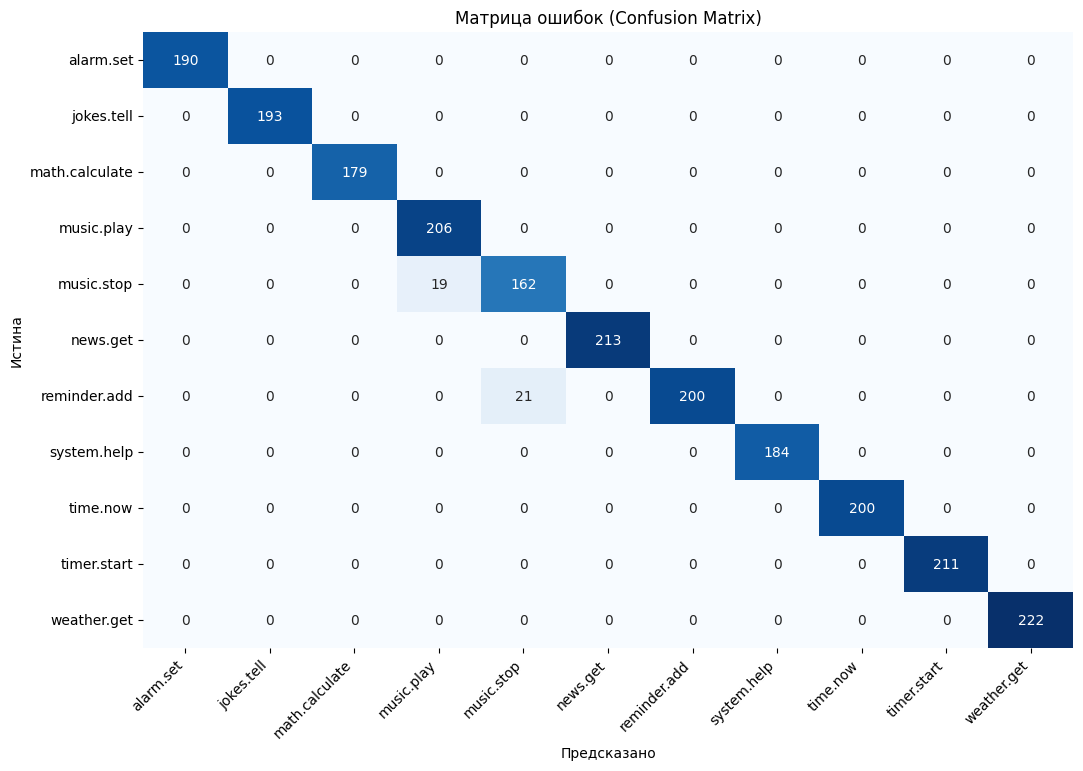

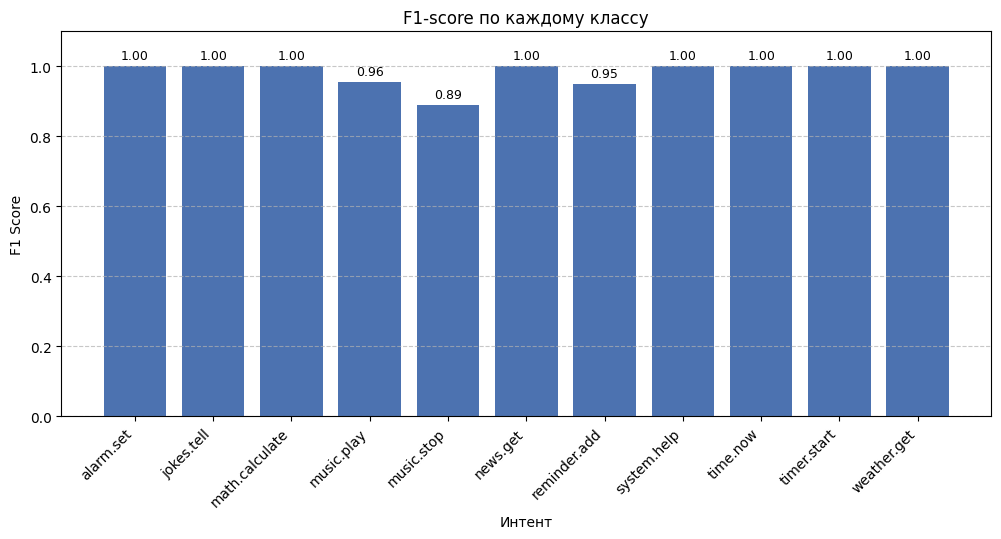

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from IPython.display import display

# 1. Подготовка списков истинных меток и предсказаний
print(f"Оценка на отложенной выборке ({len(dev_rows)} примеров)...")

y_true = []
y_pred = []

# Используем dev_rows (загружен в начале ноутбука)
for row in dev_rows:
    text = row['text']
    true_skill = row['skill']
    
    # Получаем предсказание через нашу функцию-обертку
    # (или можно использовать detector.detect(text).skill)
    res = rank_skill(text)
    predicted_skill = res['intent']
    
    y_true.append(true_skill)
    y_pred.append(predicted_skill)

# 2. Список всех уникальных классов (для осей графиков)
labels = sorted(list(set(y_true) | set(y_pred)))

# 3. Расчет метрик
acc = accuracy_score(y_true, y_pred)
print(f"\nОбщая точность (Accuracy): {acc:.3f}")

# Детальный отчет (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

# 4. Функция для отрисовки матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Предсказано")
    plt.ylabel("Истина")
    plt.title("Матрица ошибок (Confusion Matrix)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# 5. Функция для графика F1 по классам
def plot_f1_scores(y_true, y_pred, labels):
    p, r, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    df_metrics = pd.DataFrame({"Skill": labels, "F1": f1})
    
    plt.figure(figsize=(12, 5))
    plt.bar(df_metrics["Skill"], df_metrics["F1"], color="#4c72b0")
    plt.ylim(0, 1.1)
    plt.xlabel("Интент")
    plt.ylabel("F1 Score")
    plt.title("F1-score по каждому классу")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Добавляем значения над столбцами
    for i, v in enumerate(df_metrics["F1"]):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)
        
    plt.show()

# Отрисовка
plot_confusion_matrix(y_true, y_pred, labels)
plot_f1_scores(y_true, y_pred, labels)

# Тест

In [18]:
def run_interactive_test():

    while True:
        try:
            # Поле ввода
            query = input("\nВведите запрос >>> ").strip()
        except (KeyboardInterrupt, EOFError):
            break

        # Проверка на выход
        if query.lower() in {'q', 'quit', 'exit'}:
            print("Завершение работы.")
            break

        if not query:
            continue

        # --- ЗАПУСК ДЕТЕКТОРА ---
        # Мы используем detector.detect() напрямую, чтобы получить полный объект с деталями
        result = detector.detect(query)

        # --- ВЫВОД РЕЗУЛЬТАТОВ ---
        print("-" * 40)
        
        # Визуализируем, как модель "видит" текст (маскирование)
        masked_view = mask_entities(query).masked
        print(f"Запрос:      {result.query}")
        print(f"Маска:       {masked_view}")
        
        # Основное решение
        status = result.skill
        if result.skill == "system.help" and result.confidence < 0.01:
            status = "ABSTAIN (Не поняла)"
            
        print(f"ПРЕДСКАЗАНИЕ: {status}")
        print(f"Уверенность:  {result.confidence:.3f}")
        
        if result.slots:
            print(f"Слоты:        {result.slots}")
            
        if result.matched_example:
            print(f"Похожий пример: {result.matched_example}")

        # Таблица кандидатов (почему выбрали именно этот интент)
        if result.candidates:
            print("\nТоп кандидатов:")
            for i, c in enumerate(result.candidates[:5]):
                # c['entry'].skill - имя скилла
                # c['score'] - итоговый балл
                # c['sim'] - сходство по смыслу (FAISS)
                print(f"  {i+1}. {c['entry'].skill:<18} | Score: {c['score']:.3f} (Sim: {c['sim']:.3f})")

        # Отклоненные варианты (почему НЕ выбрали другие)
        # Это самое полезное для отладки негативных примеров
        if result.rejected:
            print("\nОтклонено (фильтры):")
            for reason in result.rejected:
                print(f"  [X] {reason}")
                
        print("=" * 60)

# Запуск цикла
run_interactive_test()

----------------------------------------
Запрос:      поставь погоду
Маска:       поставь {song}
ПРЕДСКАЗАНИЕ: music.play
Уверенность:  0.670
Слоты:        {'song': ['погоду'], 'song_canon': ['погоду']}
Похожий пример: поставь что‑нибудь из спокойную музыку

Топ кандидатов:
  1. music.play         | Score: 0.670 (Sim: 1.000)
  2. music.stop         | Score: 0.630 (Sim: 1.000)
  3. reminder.add       | Score: 0.630 (Sim: 1.000)
  4. music.stop         | Score: 0.630 (Sim: 1.000)
  5. reminder.add       | Score: 0.630 (Sim: 1.000)
Завершение работы.
